<a href="https://colab.research.google.com/github/Lucs1590/PID/blob/master/homework_5/face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install mtcnn
!pip install keras_vggface
!pip install keras_applications
import os
import cv2
import random
import glob
import gdown
import tarfile
import zipfile
import shutil

import numpy as np
import tensorflow as tf

from os import path
from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow
from PIL import Image
from mtcnn import MTCNN
from skimage import feature
from natsort import natsorted
from sklearn.svm import LinearSVC
from scipy.spatial.distance import cosine
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras.models import Model

""" Metrics import """
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, auc
# from CMC import CMC

# Get Faces Dataset (ARFACE)
First, we will check if the data set is here, if not, we will download it.


In [2]:
def unzip_file(_file, destination):
    with zipfile.ZipFile(_file, 'r') as zip_ref:
        zip_ref.extractall(destination)
    os.remove(_file)


In [3]:
def get_dataset(output, destination, url):
    try:
        gdown.download(url, output, quiet=False)
        unzip_file(output, destination)

    except Exception:
        raise ConnectionError(
            'you need to be connected to some internet network to download the database.')


In [4]:
def load_dataset(_path):
    destination = _path + '/arface'
    dataset_file = destination + '/arface.zip'

    if not path.isdir(destination):
        os.mkdir(destination)

    if not path.isdir(destination + '/mtcnn_detect'):
        os.mkdir(destination + '/mtcnn_detect')

    if not path.isdir(destination + '/training'):
        os.mkdir(destination + '/training')
        os.mkdir(destination + '/test')

    if not path.isdir(destination + '/lbp-detected'):
        os.mkdir(destination + '/lbp-detected')

    if not path.isdir(destination + '/vgg-detected'):
        os.mkdir(destination + '/vgg-detected')  

    if not path.isdir(destination + '/face'):
        get_dataset(dataset_file, destination, 'https://drive.google.com/u/2/uc?export=download&confirm=HiLF&id=1BQuEQfmMiA_cEYmvkQDCnYAJd_TT3rCk')
    elif path.isfile(dataset_file):
        unzip_file(dataset_file, destination)
    else:
        if path.isdir(destination + '/face'):
            print('INFO: Dataset is set!')
        else:
            raise OSError(
                'the default directory of Python is not found.')


In [5]:
os.environ['DISPLAY'] = ':0'

_path = path.abspath(os.getcwd())

print('INFO: Dataset verify')
load_dataset(_path)

_path1 = _path + '/arface'
_path2 = _path + '/ocular'
_path3 = _path + '/equalized-face'
_path4 = _path + '/equalized-ocular'

INFO: Dataset verify
INFO: Dataset is set!


In [6]:
''' import shutil
import os

_path = os.path.abspath(os.getcwd())
destination = _path4
shutil.rmtree(destination) '''

' import shutil\nimport os\n\n_path = os.path.abspath(os.getcwd())\ndestination = _path4\nshutil.rmtree(destination) '

# MTCNN Face Detection

In [7]:
def has_files(_path):
    files = glob.glob(path.join(_path, "*.bmp")).copy()
    return True if len(files) else False


In [8]:
def plot_poits(_image, detected_face):
  if len(detected_face):
    x1,y1,x2,y2 = detected_face[0]['box']
    _image = cv2.rectangle(_image, (x1, y1), (x2, y2), (255,0,0), 2)
    for point in detected_face[0]['keypoints'].values():
      x,y = point
      _image = cv2.circle(_image, (x,y), radius=1, color=(0, 0, 255), thickness=3)
  return _image

In [9]:
def get_random_image(_path):
  return random.choice(glob.glob(path.join(_path, "*.bmp")))

In [10]:
def copy_file(file, destination):
    if not path.isfile(destination):
        shutil.copy2(file, destination)


In [11]:
def save_file(detected_face, img, destination, file_name, required_size=(224, 224)):
    x1, y1, width, height = detected_face[0]['box']
    x2, y2 = x1 + width, y1 + height
    y1 = y1 if y1 >= 0 else 0
    y2 = y2 if y2 >= 0 else 0
    x1 = x1 if x1 >= 0 else 0
    x2 = x2 if x2 >= 0 else 0

    y1 = y1 if y1 <= img.shape[0] else img.shape[0]
    y2 = y2 if y2 <= img.shape[0] else img.shape[0]
    x1 = x1 if x1 <= img.shape[1] else img.shape[1]
    x2 = x2 if x2 <= img.shape[1] else img.shape[1]

    face = img[y1:y2, x1:x2]
    image = Image.fromarray((face).astype(np.uint8))
    image = image.resize(required_size)
    image.save(destination+os.path.sep+file_name)


In [12]:
def detect_faces_mtcnn(_path):
  if not has_files(_path+'/mtcnn_detect'):
    get_dataset(_path+'/mtcnn.zip', _path,'https://drive.google.com/u/2/uc?export=download&confirm=HiLF&id=1t9qlGs3VNvTWbjAL1-r5dRqn9DxyfipX')


In [13]:
print('INFO: Run MTCNN')
detect_faces_mtcnn(_path1)

INFO: Run MTCNN


# Divide Dataset

In [14]:
def divide_dataset(_path, _path_destination, percentage_train=80, percentage_test=20):
    pictures = glob.glob(path.join(_path_destination, "*.bmp")).copy()
    training_path = _path+'/training'
    test_path = _path+'/test'

    total_images = len(pictures)

    percentage_train = (percentage_train/100)
    percentage_test = (percentage_test/100)

    if has_files(training_path):
        print('Dataset already is divided!')
        return 0

    if percentage_train + percentage_test < 1 \
            or percentage_train + percentage_test > 1:
        raise ValueError('invalid train/test percentage.')

    i = 0
    while i < int(total_images*percentage_train):
        rand_image = random.choice(pictures)
        copy_file(rand_image, training_path)
        pictures.remove(rand_image)
        i += 1

    i = 0
    while i < len(pictures):
        rand_image = random.choice(pictures)
        copy_file(rand_image, test_path)
        pictures.remove(rand_image)
        i += 1

In [15]:
print('INFO: Divide dataset')
divide_dataset(_path1, _path1 + '/mtcnn_detect',80, 20)

INFO: Divide dataset
Dataset already is divided!


0

# Performance Metrics
Here we use metrics like ROC, CMC, Rank-1, Precision-Recall, EER, F-Measure, AUC (Area Under Curve).

In [16]:
def calcule_f1(predicted, true):
    f1_value = f1_score(true, predicted, average='micro')
    print('F1 Score: ', f1_value)
    return f1_value

In [17]:
def compute_precision_recall(label, score):
    Y = OneHotEncoder().fit_transform(np.array(label).reshape(-1, 1)).toarray()

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(Y.shape[1]):
        precision[i], recall[i], _ = precision_recall_curve(
            Y[:, i], score[:, i])
        average_precision[i] = average_precision_score(Y[:, i], score[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y.ravel(), score[:, :Y.shape[1]].ravel())
    average_precision["micro"] = average_precision_score(
        Y, score[:, :Y.shape[1]], average="micro")

    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))
    plt.show()

In [18]:
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

default_color = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'brown']
default_marker = ['*', 'o', 's', 'v', 'X', '*', '.', 'P']


class CMC:
    def __init__(self, cmc_dict, color=default_color, marker=default_marker):
        self.color = color
        self.marker = marker
        self.cmc_dict = cmc_dict

    def plot(self, title, rank=20, xlabel='Rank', ylabel='Matching Rates (%)', show_grid=True):
        fig, ax = plt.subplots()
        fig.suptitle(title)
        x = list(range(0, rank+1, 5))
        plt.ylim(0, 1.0)
        plt.xlim(1, rank)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(x)
        plt.grid(show_grid)

        method_name = []
        i = 0
        for name in self.cmc_dict.keys():
            if rank < len(self.cmc_dict[name]):
                temp_cmc = self.cmc_dict[name][:rank]
                r = list(range(1, rank+1))
            else:
                temp_cmc = self.cmc_dict[name]
                r = list(range(1, len(temp_cmc)+1))

            if name == list(self.cmc_dict.keys())[-1]:

                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[0],
                                                marker=self.marker[0], label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
            else:
                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[i+1],
                                                marker=self.marker[i+1], label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
                i = i+1
            ax.add_line(globals()[name])
            method_name.append(globals()[name])

        plt.legend(handles=method_name)
        plt.show()

    def save(self, title, filename,
             rank=20, xlabel='Rank',
             ylabel='Matching Rates (%)', show_grid=True,
             save_path=os.getcwd(), format='png', **kwargs):
        fig, ax = plt.subplots()
        fig.suptitle(title)
        x = list(range(0, rank+1, 5))
        plt.ylim(0, 1.0)
        plt.xlim(1, rank)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(x)
        plt.grid(show_grid)

        method_name = []
        i = 0
        for name in self.cmc_dict.keys():
            if rank < len(self.cmc_dict[name]):
                temp_cmc = self.cmc_dict[name][:rank]
                r = list(range(1, rank+1))
            else:
                temp_cmc = self.cmc_dict[name]
                r = list(range(1, len(temp_cmc)+1))

            if name == list(self.cmc_dict.keys())[-1]:
                globals()[name] = mlines.Line2D(r, temp_cmc, color='r', marker='*',
                                                label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
            else:
                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[i],
                                                marker=self.marker[i], label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
                i = i+1
            ax.add_line(globals()[name])
            method_name.append(globals()[name])

        plt.legend(handles=method_name)
        fig.savefig(os.path.join(save_path, filename+'.'+format),
                    format=format,
                    bbox_inches='tight',
                    pad_inches=0, **kwargs)

In [19]:
def making_cmc(values, keys):
    i = 0
    default_array = []
    cmc_dict = {}

    while i < 5:
        default_array.append(keys.index(random.choice(keys)))
        i += 1

    i = 0
    while i < len(default_array):
        cmc_dict[keys[default_array[i]]] = values[[default_array[i]]].squeeze().tolist()
        i += 1

    cmc = CMC(cmc_dict)
    cmc.plot(title='CMC', xlabel='Rank Score', ylabel='Recognition Rate')

In [20]:
def make_roc_curve(label, score):
    Y = OneHotEncoder().fit_transform(np.array(label).reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(Y.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        Y.ravel(), score[:, :Y.shape[1]].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    eer(fpr["micro"], tpr["micro"])

In [21]:
def eer(fpr_list, tpr_list):
    err = brentq(lambda x: 1. - x - interp1d(fpr_list, tpr_list)(x), 0., 1.)
    print(err)
    return err


# Local Binary Pattern (LBP)

In [22]:

class LocalBinaryPatterns:
    def __init__(self, num_points, radius):
        self.numPoints = num_points
        self.radius = radius

    def describe(self, image, eps=1e-5):
        lbp = feature.local_binary_pattern(image, self.numPoints,
                                           self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, self.numPoints + 3),
                                 range=(0, self.numPoints + 2))

        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        return hist


In [23]:
def run_lbp(_path):
    desc = LocalBinaryPatterns(40, 8)
    faces = []
    labels = []
    pictures = glob.glob(path.join(_path, "*.bmp")).copy()
    pictures = natsorted(pictures)

    for _file in pictures:
        try:
            gray_img = cv2.cvtColor(cv2.imread(_file), cv2.COLOR_BGR2GRAY)
            hist = desc.describe(gray_img)

            if len(hist) > 0:
                labels.append(
                    ''.join(_file.split(os.path.sep)[-1].split('-')[0:2]))
                faces.append(hist)
        except Exception:
            pass

    model = LinearSVC(C=100.0, random_state=42)
    model.fit(faces, labels)

    return faces, labels, model

In [24]:
def classify_lbp(_path, model):
    desc = LocalBinaryPatterns(40, 8)
    hit = 0
    miss = 0
    hist_list = []
    label_list = []
    predicted_values_list = []

    pictures = glob.glob(path.join(_path+'/test', "*.bmp")).copy()
    pictures = natsorted(pictures)

    for _file in pictures:
        image = cv2.imread(_file)
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hist = desc.describe(gray_img)
        prediction = model.predict(hist.reshape(1, -1))
        correct_class = ''.join(_file.split(os.path.sep)[-1].split('-')[0:2])

        if prediction[0] == correct_class:
            hit += 1
        else:
            miss += 1

        cv2.putText(image, prediction[0], (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1.0, (0, 0, 255), 3)
        cv2.imwrite(_path+'/lbp-detected/'+_file.split(os.path.sep)[-1], image)

        hist_list.append(hist.reshape(1, -1))
        label_list.append(correct_class)
        predicted_values_list.append(prediction[0])

    calcule_f1(predicted_values_list, label_list)
    data = np.array(hist_list).squeeze()
    score = model.decision_function(data)
    making_cmc(score, label_list)
    compute_precision_recall(label_list, score)
    make_roc_curve(label_list, score)

    print(hit, miss)
    return hit, miss

In [25]:
print('INFO: Run LBP')
(faces_desc_lbp, labels_face_lbp, lbp_face_model) = run_lbp(_path1 + '/training')

INFO: Run LBP


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


INFO: Classifing Images (LBP)
F1 Score:  0.25


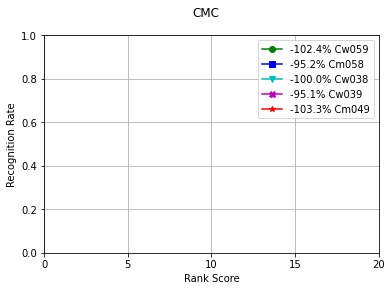

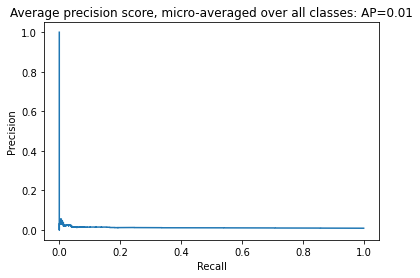

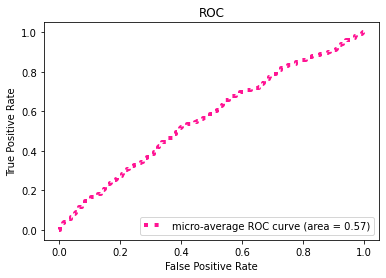

0.4523823392350612
74 222


(74, 222)

In [26]:
print('INFO: Classifing Images (LBP)')
classify_lbp(_path1, lbp_face_model)

# VGGFACE

In [32]:
def run_vgg(_model, _path):
    pictures = glob.glob(path.join(_path+'/training', "*.bmp")).copy()
    pictures = natsorted(pictures)

    faces = []
    labels = []

    for _file in pictures:
        try:
            img = cv2.cvtColor(cv2.imread(_file), cv2.COLOR_BGR2RGB)
            labels.append(
                ''.join(_file.split(os.path.sep)[-1].split('-')[0:2]))
            faces.append(img)
        except Exception:
            pass

    encoded_labels = OneHotEncoder().fit_transform(
        np.array(labels).reshape(-1, 1)).toarray()

    model = define_vgg_model(_model, len(np.unique(np.array(labels))))
    model.fit(np.array(faces), encoded_labels, epochs=2)

    return faces, labels, model

In [33]:
def define_vgg_model(_mode, num_class):
    base_model = VGGFace(model='resnet50', include_top=False)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='elu', name='fc1')(x)
    x = tf.keras.layers.Dense(196, activation='elu', name='fc2')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    predictions = tf.keras.layers.Dense(
        num_class, activation='softmax', name='predictions')(x)
    model = Model(base_model.input, predictions)

    for layer in model.layers:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [34]:
def classify_vgg(_path, model, labels):
    hit = 0
    miss = 0
    label_list = []
    score_list = []
    predicted_values_list = []

    pictures = glob.glob(path.join(_path+'/test', "*.bmp")).copy()
    pictures = natsorted(pictures)

    encoder = OneHotEncoder()
    encoded_labels = encoder.fit_transform(
        np.array(labels).reshape(-1, 1)).toarray()
    encoder.fit_transform(np.array(labels).reshape(-1, 1))
    labels = encoder.inverse_transform(encoded_labels)

    for _file in pictures:
        image = cv2.imread(_file)
        rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float32')
        samples = np.expand_dims(rgb_img, axis=0)
        samples = preprocess_input(samples, version=2)
        prediction = model.predict(samples)
        correct_class = ''.join(_file.split(os.path.sep)[-1].split('-')[0:2])

        idx_best_prediction = np.argmax(prediction[0])
        best_prediction = labels[idx_best_prediction][0]

        if best_prediction == correct_class:
            hit += 1
        else:
            miss += 1

        cv2.putText(image, best_prediction, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
        cv2.imwrite(_path+'/vgg-detected/'+_file.split(os.path.sep)[-1], image)

        label_list.append(correct_class)
        score_list.append(prediction)
        predicted_values_list.append(best_prediction)

    calcule_f1(predicted_values_list, label_list)
    making_cmc(np.array(score_list).squeeze(), label_list)
    compute_precision_recall(label_list, np.array(score_list).squeeze())
    make_roc_curve(label_list, np.array(score_list).squeeze())

    print(hit, miss)
    return hit, miss

In [35]:
print('INFO: Run VGGFACE')
(faces_desc_vgg, labels_face_vgg, vgg_face_model) = run_vgg('resnet50', _path1)

INFO: Run VGGFACE
Epoch 1/2
74/74 [==============================] - 322s 4s/step - loss: 8.3945 - accuracy: 0.0030
Epoch 2/2
74/74 [==============================] - 321s 4s/step - loss: 8.2217 - accuracy: 0.0043


INFO: Classifing Images (VGGFACE2)
F1 Score:  0.0033783783783783786


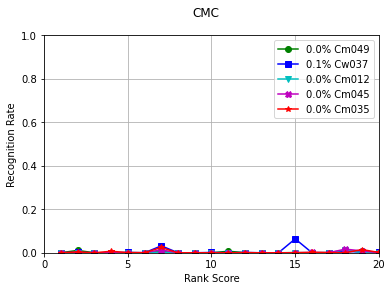

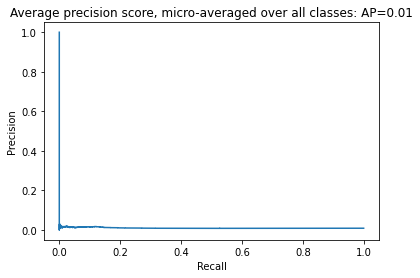

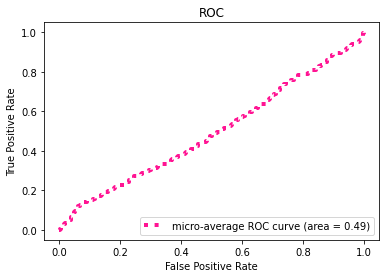

0.5117660764213741
1 295


(1, 295)

In [36]:
print('INFO: Classifing Images (VGGFACE2)')
classify_vgg(_path1, vgg_face_model, labels_face_vgg)

In [ ]:
# model_pic = _path + '/model.png'
# tf.keras.utils.plot_model(vgg_model, to_file=model_pic, show_shapes=True)

# Ocular Detection

In [37]:
def load_dataset_ocular(_path):
    destination_1 = _path + '/ocular'
    destination = _path + '/arface'

    if not path.isdir(destination):
        os.mkdir(destination)

    if not path.isdir(destination_1):
        os.mkdir(destination_1)

    if not path.isdir(destination_1 + '/default_detect'):
        os.mkdir(destination_1 + '/default_detect')

    if not path.isdir(destination_1 + '/training'):
        os.mkdir(destination_1 + '/training')
        os.mkdir(destination_1 + '/test')

    if not path.isdir(destination_1 + '/lbp-detected'):
        os.mkdir(destination_1 + '/lbp-detected')

    if not path.isdir(destination_1 + '/vgg-detected'):
        os.mkdir(destination_1 + '/vgg-detected')

In [38]:
print('INFO: Dataset verify (OCULAR)')
load_dataset_ocular(_path)

INFO: Dataset verify (OCULAR)


In [39]:
def standardize_images_ocular(_paths, destination):
    if has_files(destination):
        print('Dataset is already standardized!')
        return 0

    for _path in _paths:
        pictures = glob.glob(path.join(_path, "*.bmp")).copy()
        pictures = natsorted(pictures)

        for _file in pictures:
            img = cv2.cvtColor(cv2.imread(_file), cv2.COLOR_BGR2RGB)
            save_file_ocular(img, destination, _file.split(os.path.sep)[-1])

In [40]:
def save_file_ocular(img, destination, file_name, required_size=(224, 224)):
    image = Image.fromarray((img).astype(np.uint8))
    image = image.resize(required_size)
    image.save(destination+os.path.sep+file_name)

In [41]:
print('INFO: Standardize Images')
standardize_images_ocular([_path1 + '/left', _path1 + '/right'],
                          _path2 + '/default_detect')

INFO: Standardize Images
Dataset is already standardized!


0

In [42]:
print('INFO: Divide dataset (OCULAR)')
divide_dataset(_path2, _path2 + '/default_detect',80, 20)

INFO: Divide dataset (OCULAR)
Dataset already is divided!


0

In [43]:
print('INFO: Run LBP (OCULAR)')
(oc_regions_desc_lbp, oc_regions_labels_lbp, oc_regions_lbp_model) = run_lbp(_path2 + '/training')

INFO: Run LBP (OCULAR)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


INFO: Classifing Images (LBP - OCULAR)
F1 Score:  0.18251533742331288


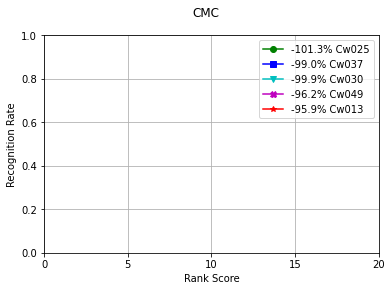

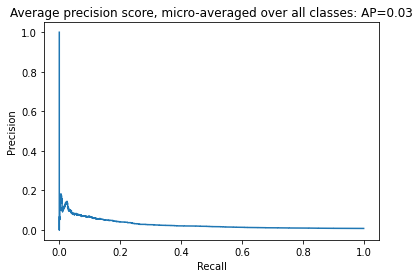

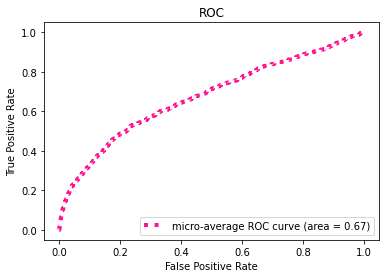

0.3765395082790572
119 533


(119, 533)

In [44]:
print('INFO: Classifing Images (LBP - OCULAR)')
classify_lbp(_path2, oc_regions_lbp_model)

In [45]:
print('INFO: Run VGGFACE (OCULAR)')
(oc_regions_desc_vgg, oc_regions_labels_vgg, oc_regions_vgg_model) = run_vgg('resnet50', _path2)

INFO: Run VGGFACE (OCULAR)
Epoch 1/2
163/163 [==============================] - 695s 4s/step - loss: 5.2494 - accuracy: 0.0046
Epoch 2/2
163/163 [==============================] - 698s 4s/step - loss: 5.2572 - accuracy: 0.0060


INFO: Classifing Images (VGGFACE2 - OCULAR)
F1 Score:  0.007668711656441719


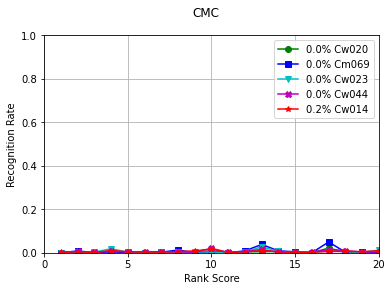

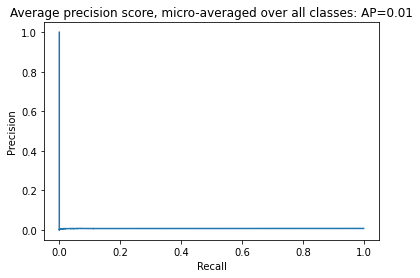

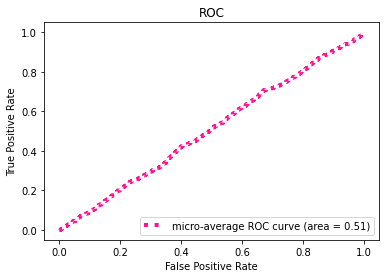

0.49636745237150603
5 647


(5, 647)

In [46]:
print('INFO: Classifing Images (VGGFACE2 - OCULAR)')
classify_vgg(_path2, oc_regions_vgg_model, oc_regions_labels_vgg)

# Apply Filters
In this step, filters are placed randomly in the image, so that it is possible to visualize the influence of factors such as lighting, for example.

In [47]:
def load_dataset_equalized(_path, names):
    for name in names:
        destination_1 = _path + '/ocular'
        destination_2 = _path + '/' + name
        destination = _path + '/arface'

        if not path.isdir(destination):
            os.mkdir(destination)

        if not path.isdir(destination_1):
            os.mkdir(destination_1)

        if not path.isdir(destination_2):
            os.mkdir(destination_2)

        if not path.isdir(destination_2 + '/default_detect'):
            os.mkdir(destination_2 + '/default_detect')

        if not path.isdir(destination_2 + '/training'):
            os.mkdir(destination_2 + '/training')
            os.mkdir(destination_2 + '/test')

        if not path.isdir(destination_2 + '/lbp-detected'):
            os.mkdir(destination_2 + '/lbp-detected')

        if not path.isdir(destination_2 + '/vgg-detected'):
            os.mkdir(destination_2 + '/vgg-detected')

In [48]:
def histogram_equalization(_path_dataset, destination):
    pictures = glob.glob(path.join(_path_dataset, "*.bmp")).copy()
    pictures = natsorted(pictures)

    for _file in pictures:
        img = cv2.cvtColor(cv2.imread(_file), cv2.COLOR_BGR2HSV)
        img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
        image = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

        cv2.imwrite(destination+'/'+_file.split(os.path.sep)[-1], image)

In [49]:
print('INFO: Dataset verify (EQUALIZED)')
_path = path.abspath(os.getcwd())

load_dataset_equalized(_path, ['equalized-face','equalized-ocular'])
_path1 = _path + '/arface'
_path2 = _path + '/ocular'
_path3 = _path + '/equalized-face'
_path4 = _path + '/equalized-ocular'

INFO: Dataset verify (EQUALIZED)


In [50]:
print('INFO: Applying Equalization')
histogram_equalization(_path1 + '/mtcnn_detect',_path3 + '/default_detect')
histogram_equalization(_path2 + '/default_detect', _path4 + '/default_detect')

INFO: Applying Equalization


In [51]:
print('INFO: Divide dataset (EQUALIZED)')
divide_dataset(_path3, _path3 + '/default_detect',80, 20)
divide_dataset(_path4, _path4 + '/default_detect',80, 20)

INFO: Divide dataset (EQUALIZED)


In [52]:
print('INFO: Run LBP (EQUALIZED)')
(eql_face_desc_lbp, eql_face_labels_lbp, eql_face_lbp_model) = run_lbp(_path3 + '/training')
(eql_ocular_desc_lbp, eql_ocular_labels_lbp, eql_ocular_lbp_model) = run_lbp(_path4 + '/training')

INFO: Run LBP (EQUALIZED)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


INFO: Classifing Images (LBP - EQUALIZED)
F1 Score:  0.25


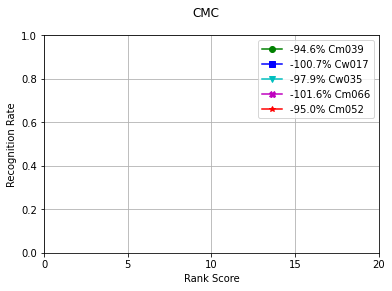

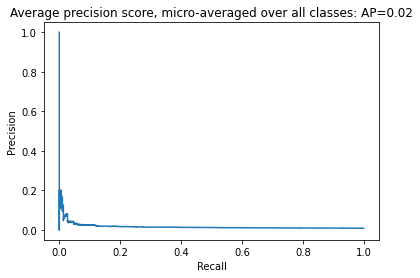

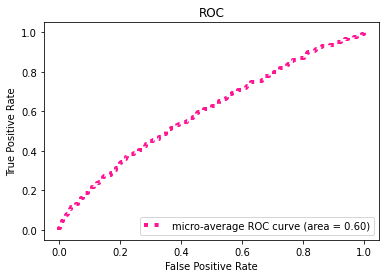

0.4358108108108108
74 222
F1 Score:  0.12116564417177914


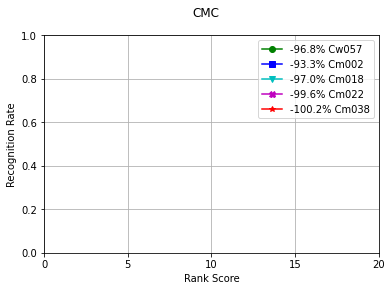

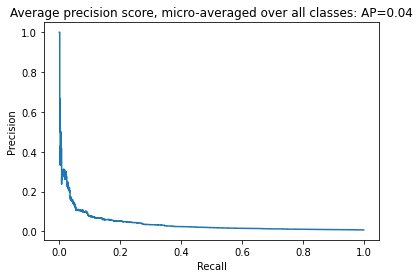

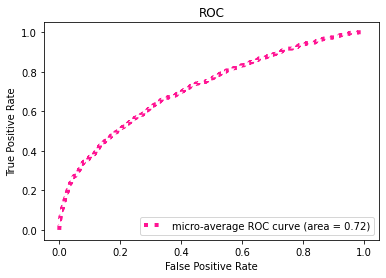

0.33940344290835633
79 573


(79, 573)

In [53]:
print('INFO: Classifing Images (LBP - EQUALIZED)')
classify_lbp(_path3, eql_face_lbp_model)
classify_lbp(_path4, eql_ocular_lbp_model)

In [54]:
print('INFO: Run VGGFACE (EQUALIZED)')
(eql_face_desc_vgg, eql_face_labels_vgg, eql_face_vgg_model) = run_vgg('resnet50', _path3)
(eql_ocular_desc_vgg, eql_ocular_labels_vgg, eql_ocular_vgg_model) = run_vgg('resnet50', _path4)

INFO: Run VGGFACE (EQUALIZED)
Epoch 1/2
74/74 [==============================] - 325s 4s/step - loss: 7.4224 - accuracy: 0.0107
Epoch 2/2
74/74 [==============================] - 320s 4s/step - loss: 7.3974 - accuracy: 0.0085
Epoch 1/2
163/163 [==============================] - 706s 4s/step - loss: 5.2286 - accuracy: 0.0098
Epoch 2/2
163/163 [==============================] - 707s 4s/step - loss: 5.2523 - accuracy: 0.0080


INFO: Classifing Images (VGGFACE2 - EQUALIZED)
F1 Score:  0.006756756756756757


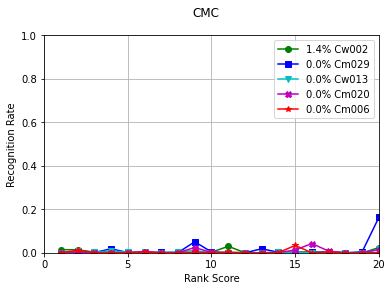

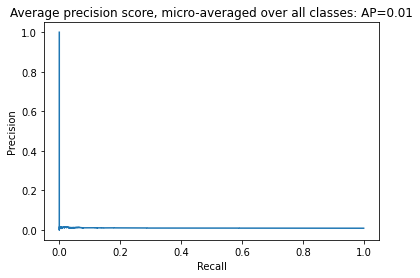

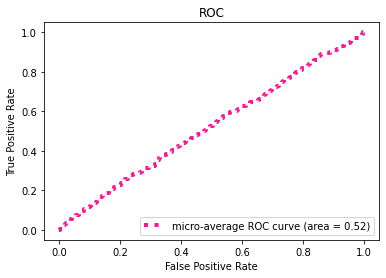

0.4864864864864042
2 294
F1 Score:  0.010736196319018405


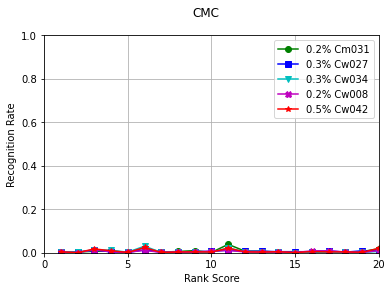

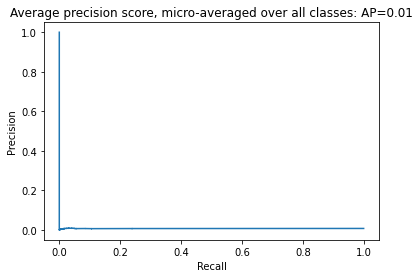

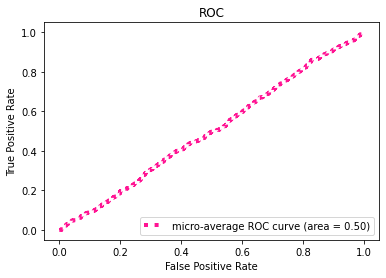

0.5015337423312883
7 645


(7, 645)

In [55]:
print('INFO: Classifing Images (VGGFACE2 - EQUALIZED)')
classify_vgg(_path3, eql_face_vgg_model, eql_face_labels_vgg)
classify_vgg(_path4, eql_ocular_vgg_model, eql_ocular_labels_vgg)

# Comparison Between Genuine and Imposter

In [56]:
def compare_images(_path, model, image1 = None, image2 = None):
    pictures = glob.glob(path.join(_path + '/mtcnn_detect', "*.bmp")).copy()
    pic1 = image1 if image1 else random.choice(pictures)
    print(pic1)
    pic2 = image2 if image2 else random.choice(pictures)
    print(pic2)

    rand_image1 = cv2.cvtColor(cv2.imread(pic1), cv2.COLOR_BGR2RGB).astype('float32')
    rand_image2 = cv2.cvtColor(cv2.imread(pic2), cv2.COLOR_BGR2RGB).astype('float32')

    sample1 = np.expand_dims(rand_image1, axis=0)
    sample1 = preprocess_input(sample1, version=2)

    sample2 = np.expand_dims(rand_image2, axis=0)
    sample2 = preprocess_input(sample2, version=2)

    prediction1 = model.predict(sample1)
    prediction2 = model.predict(sample2)

    is_match(prediction1, prediction2)

In [57]:
def is_match(known_embedding, candidate_embedding, thresh=0.5):
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
        print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
    else:
        print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

In [68]:
print('INFO: Compare images')
compare_images(_path1, vgg_face_model)

INFO: Compare images
/content/arface/mtcnn_detect/Cw-022-3_face.bmp
/content/arface/mtcnn_detect/Cm-012-9_face.bmp
>face is a Match (0.216 <= 0.500)
